In [ ]:
import re
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from collections import Counter

home = os.path.expanduser("~")
data_dir = os.path.join(home, 'Documents/semantic-robot/testing/results')

def shape(alist):
    print('(' + str(len(alist)) + ', ' + str(len(alist[0])) + ')')

### Extract necessary data

In [ ]:
def extract_data(filename):
    with open(filename) as f:
        content = f.read()
    
    prompt = re.findall(r'Prompt number\s+:\s+(.+)', content)
    test_sets = re.findall(r'Test set #\s+:\s+(.+)', content)
    number_of_examples = re.findall(r'Number of examples\s+:\s+(.+)', content)
    inference_times = re.findall(r'Inference time \[s\]\s+:\s+(.+)', content)
    memory_usage = re.findall(r'GPU memory loaded \[MB\]\s+:\s+(.+)', content)
    input_size = re.findall(r'Model input size \[MB\]\s+:\s+(.+)', content)
    model = re.findall(r'Model\s+:\s+(.+)', content)
    sliced_output = re.findall(r'Sliced output\s+:\s+(.+)', content)
    solution = re.findall(r'Solution\s+:\s+(.+)', content)
    labeled = re.findall(r'Labeled\s+:\s+(.+)', content)
    knowledge = re.findall(r'Generated knowledge\s+:\s+(.+)', content)

    return {
        'model': list(map(str, model)),
        'prompt': list(map(int, prompt)),
        'test_set': list(map(int, test_sets)),
        'num_examples': list(map(int, number_of_examples)),
        'sliced_output': list(map(str, sliced_output)),
        'solution': list(map(str, solution)),
        'inference_time': list(map(float, inference_times)),
        'memory_usage': list(map(float, memory_usage)),
        'input_size': list(map(float, input_size)),
        'labeled': list(map(str, labeled)),
        'knowledge': list(map(str, knowledge))
    }

In [ ]:
data = extract_data(os.path.join(data_dir, 'mistral_test_results_specific.txt'))

df = pd.DataFrame(data)

In [ ]:
knowledge_df = df.loc[df['knowledge'] == 'Yes']
no_knowledge_df = df.loc[df['knowledge'] == 'No']

# split knowledge_df and no_knowledge_df by prompt number 1-3
knowledge_df_1 = knowledge_df.loc[knowledge_df['prompt'] == 1]
knowledge_df_2 = knowledge_df.loc[knowledge_df['prompt'] == 2]
knowledge_df_3 = knowledge_df.loc[knowledge_df['prompt'] == 3]

no_knowledge_df_1 = no_knowledge_df.loc[no_knowledge_df['prompt'] == 1]
no_knowledge_df_2 = no_knowledge_df.loc[no_knowledge_df['prompt'] == 2]
no_knowledge_df_3 = no_knowledge_df.loc[no_knowledge_df['prompt'] == 3]

# create outputs which is a list of 10 lists
outputs = [[] for i in range(10)]

for i in range(len(outputs)):
    outputs[i].append(knowledge_df_1['sliced_output'].iloc[i])
    outputs[i].append(knowledge_df_2['sliced_output'].iloc[i])
    outputs[i].append(knowledge_df_3['sliced_output'].iloc[i])
    outputs[i].append(no_knowledge_df_1['sliced_output'].iloc[i])
    outputs[i].append(no_knowledge_df_2['sliced_output'].iloc[i])
    outputs[i].append(no_knowledge_df_3['sliced_output'].iloc[i])

dfs = [knowledge_df_1, knowledge_df_2, knowledge_df_3, no_knowledge_df_1, no_knowledge_df_2, no_knowledge_df_3]

#### Inference time

In [ ]:
# create a plot with the dfs[i]['inference_time']
fig, ax = plt.subplots()
for i in range(len(dfs)):
    if i < 3:
        ax.plot(dfs[i]['num_examples'], dfs[i]['inference_time'], label=f'Prompt {i+1} knowledge')
    else:
        ax.plot(dfs[i]['num_examples'], dfs[i]['inference_time'], label=f'Prompt {i-2} no knowledge')

ax.set_xlabel('Number of examples')
ax.set_ylabel('Inference time [s]')
ax.set_title('Inference time for different prompts and knowledge')
ax.legend()
ax.grid()
plt.show()

# compute the average inference_time for each prompt and knowledge and make a bar plot
inference_times = []

for i in range(len(dfs)):
    inference_times.append(dfs[i]['inference_time'].mean())

# create a grouped bar plot with the inference times, where the pairs are dfs[0] and dfs[3], dfs[1] and dfs[4], dfs[2] and dfs[5]
barWidth = 0.25
r1 = np.arange(len(inference_times)//2)  # change here
r2 = [x + barWidth for x in r1]

plt.bar(r1, inference_times[:3], width=barWidth, label='Knowledge')
plt.bar(r2, inference_times[3:6], width=barWidth, label='No knowledge')  # change here

plt.xlabel('Prompt')
plt.ylabel('Inference time [s]')
plt.title('Average inference time for different prompts and knowledge')
plt.xticks([r + barWidth/2 for r in range(len(inference_times[:3]))], ['1', '2', '3'])
plt.legend()
plt.savefig('avg_inf_time_specific.pdf', format='pdf')
plt.show()


# Mistral output plots

In [ ]:
solution_instances = np.array([
    {'pallet_1': 'pallet'},
    {},
    {'pallet_1': 'pallet', 'pallet_2': 'pallet'},
    {'pallet_1': 'pallet', 'pallet_2': 'pallet'},
    {'pallet_1': 'pallet', 'pallet_2': 'pallet', 'pallet_3': 'pallet', 'pallet_4': 'pallet', 'pallet_5': 'pallet', 'pallet_6': 'pallet'},
    {'pallet_1': 'pallet', 'pallet_2': 'pallet', 'pallet_3': 'pallet', 'pallet_4': 'pallet', 'pallet_5': 'pallet', 'pallet_6': 'pallet', 'pallet_7': 'pallet', 'pallet_8': 'pallet', 'pallet_9': 'pallet', 'pallet_10': 'pallet'},
    {'pallet_1': 'pallet', 'pallet_2': 'pallet'},
    {'pallet_1': 'pallet', 'pallet_2': 'pallet'},
    {'pallet_11': 'pallet'},
    {'pallet_1': 'pallet', 'pallet_2': 'pallet', 'pallet_3': 'pallet', 'pallet_4': 'pallet'},
    {'pallet_13': 'pallet'},
])

solution_predicates = np.array([
    {'pallet_1 unload_zone': 'pallet_at', 'pallet_1': 'pallet_not_moved'},
    {},
    {'pallet_1 unload_zone': 'pallet_at', 'pallet_1': 'pallet_not_moved', 'pallet_2 unload_zone': 'pallet_at', 'pallet_2': 'pallet_not_moved'},
    {'pallet_1 unload_zone': 'pallet_at', 'pallet_1': 'pallet_not_moved', 'pallet_2 unload_zone': 'pallet_at', 'pallet_2': 'pallet_not_moved'},
    {'pallet_1 unload_zone': 'pallet_at', 'pallet_1': 'pallet_not_moved', 'pallet_2 unload_zone': 'pallet_at', 'pallet_2': 'pallet_not_moved', 'pallet_3 unload_zone': 'pallet_at', 'pallet_3': 'pallet_not_moved', 'pallet_4 unload_zone': 'pallet_at', 'pallet_4': 'pallet_not_moved', 'pallet_5 unload_zone': 'pallet_at', 'pallet_5': 'pallet_not_moved', 'pallet_6 unload_zone': 'pallet_at', 'pallet_6': 'pallet_not_moved'},
    {'pallet_1 unload_zone': 'pallet_at', 'pallet_1': 'pallet_not_moved', 'pallet_2 unload_zone': 'pallet_at', 'pallet_2': 'pallet_not_moved', 'pallet_3 unload_zone': 'pallet_at', 'pallet_3': 'pallet_not_moved', 'pallet_4 unload_zone': 'pallet_at', 'pallet_4': 'pallet_not_moved', 'pallet_5 unload_zone': 'pallet_at', 'pallet_5': 'pallet_not_moved', 'pallet_6 unload_zone': 'pallet_at', 'pallet_6': 'pallet_not_moved', 'pallet_7 unload_zone': 'pallet_at', 'pallet_7': 'pallet_not_moved', 'pallet_8 unload_zone': 'pallet_at', 'pallet_8': 'pallet_not_moved', 'pallet_9 unload_zone': 'pallet_at', 'pallet_9': 'pallet_not_moved', 'pallet_10 unload_zone': 'pallet_at', 'pallet_10': 'pallet_not_moved'},
    {'pallet_1 unload_zone': 'pallet_at', 'pallet_1': 'pallet_not_moved', 'pallet_2 unload_zone': 'pallet_at', 'pallet_2': 'pallet_not_moved'},
    {'pallet_1 unload_zone': 'pallet_at', 'pallet_1': 'pallet_not_moved', 'pallet_2 unload_zone': 'pallet_at', 'pallet_2': 'pallet_not_moved'},
    {'pallet_11 unload_zone': 'pallet_at', 'pallet_11': 'pallet_not_moved'},
    {'pallet_1 unload_zone': 'pallet_at', 'pallet_2 unload_zone': 'pallet_at', 'pallet_3 unload_zone': 'pallet_at', 'pallet_4 unload_zone': 'pallet_at', 'pallet_1': 'pallet_not_moved', 'pallet_2': 'pallet_not_moved', 'pallet_3': 'pallet_not_moved', 'pallet_4': 'pallet_not_moved'},
    {'pallet_13 unload_zone': 'pallet_at', 'pallet_13': 'pallet_not_moved'}
])

solution_goals = np.array([
    {'pallet_1 shelf_4': 'pallet_at'},
    {'tars shelf_2': 'robot_at'},
    {'pallet_1 shelf_2': 'pallet_at', 'pallet_2 shelf_4': 'pallet_at'},
    {'pallet_1 shelf_2': 'pallet_at', 'pallet_2 shelf_3': 'pallet_at'},
    {'pallet_1 shelf_1': 'pallet_at', 'pallet_2 shelf_1': 'pallet_at', 'pallet_3 shelf_1': 'pallet_at', 'pallet_4 shelf_2': 'pallet_at', 'pallet_5 shelf_3': 'pallet_at', 'pallet_6 shelf_4': 'pallet_at'},
    {'pallet_1 shelf_3': 'pallet_at', 'pallet_2 shelf_4': 'pallet_at', 'pallet_3 shelf_2': 'pallet_at', 'pallet_4 shelf_3': 'pallet_at', 'pallet_5 shelf_3': 'pallet_at', 'pallet_6 shelf_1': 'pallet_at', 'pallet_7 shelf_4': 'pallet_at', 'pallet_8 shelf_1': 'pallet_at', 'pallet_9 shelf_1': 'pallet_at', 'pallet_10 shelf_2': 'pallet_at'},
    {'pallet_1 shelf_1': 'pallet_at', 'pallet_2 shelf_2': 'pallet_at', 'tars shelf_4': 'robot_at'},
    {'pallet_1 shelf_4': 'pallet_at', 'pallet_2 shelf_2': 'pallet_at', 'tars charging_station': 'robot_at'},
    {'pallet_11 shelf_1': 'pallet_at', 'tars shelf_2': 'robot_at'},
    {'pallet_1 shelf_3': 'pallet_at', 'pallet_2 shelf_3': 'pallet_at', 'pallet_3 shelf_3': 'pallet_at', 'pallet_4 shelf_3': 'pallet_at'},
    {'pallet_13 shelf_2': 'pallet_at ', 'tars shelf_1': 'robot_at'}
])

In [ ]:
# for all the strings in outputs, make all chars lowercase and remove all special character '\', '#', ':', ''', '"'
for i in range(len(outputs)):
    for j in range(len(outputs[i])):
        outputs[i][j] = outputs[i][j].lower()
        outputs[i][j] = outputs[i][j].replace('\\', '')
        outputs[i][j] = outputs[i][j].replace('#', '')
        outputs[i][j] = outputs[i][j].replace(':', '')
        outputs[i][j] = outputs[i][j].replace('\'', '')
        outputs[i][j] = outputs[i][j].replace('"', '')

# print the sublists in outputs to a file
with open('outputs_specific.txt', 'w') as f:
    for i in range(len(outputs)):
        f.write(f'Test {i+1}\n')
        for j in range(len(outputs[i])):
            f.write(f'Prompt {j+1}: {outputs[i][j]}\n')
        f.write('\n')

out_instances_dicts= [[] for _ in range(len(outputs))]
out_predicates_dicts = [[] for _ in range(len(outputs))]
out_goals_dicts = [[] for _ in range(len(outputs))]

counter = 1

for i in range(len(outputs)):
    for j in range(len(outputs[i])):
        instances = outputs[i][j].split('predicate')[0]
        predicates = outputs[i][j].split('goal ')[0].replace(instances, '')
        goals = outputs[i][j].replace(instances + predicates, '')

        instances = instances.replace("|", " |")
        predicates = predicates.replace("|", " |")
        goals = goals.replace("|", " |")

        instances = instances.split()
        predicates = predicates.split()
        goals = goals.split()     

        for k in range(len(instances)):
            instances[k] = instances[k].replace("|", "")
        for k in range(len(predicates)):
            predicates[k] = predicates[k].replace("|", "")
        for k in range(len(goals)):
            goals[k] = goals[k].replace("|", "")

        instances = list(filter(None, instances))
        predicates = list(filter(None, predicates))
        goals = list(filter(None, goals))


        instances_dict = {}
        key = None
        for word in instances:
            if word == 'instance':
                if key is not None:
                    if key in instances_dict:
                        # print(f'Key {key} already exists in instances {counter}.')
                        key = key+'_copy'
                        instances_dict[key] = value
                    else:
                        instances_dict[key] = value
                key = None
                value = None
            elif key is None:
                key = word
            else:
                value = word
        if key is not None:
            if key in instances_dict:
                # print(f'Key {key} already exists in instances {counter}.')
                key = key+'_copy'
                instances_dict[key] = value
            else:    
                instances_dict[key] = value

        # create predicates dictionary
        predicates_dict = {}
        key = ''
        value = ''
        for n in range(len(predicates)):
            if predicates[n] == 'predicate':
                if key:
                    if key in predicates_dict:
                        # print(f"Key {key} already exists in predicates {counter}.")
                        key = key+'_copy'
                        predicates_dict[key] = value
                    else:
                        predicates_dict[key] = value

                value = predicates[n+1] 
                key = ' '.join(predicates[n+2:])  
                next_predicate_index = key.find('predicate') 
                if next_predicate_index != -1:
                    key = key[:next_predicate_index].strip()
        if key:
            if key in predicates_dict:
                # print(f"Key {key} already exists in predicates {counter}.")
                key = key+'_copy'
                predicates_dict[key] = value
            else:
                predicates_dict[key] = value

        # create goals dictionary
        goals_dict = {}
        key = ''
        value = ''
        for n in range(len(goals)):
            if goals[n] == 'goal':
                if key:
                    if key in goals_dict:
                        # print(f"Key {key} already exists in goals {counter}.")
                        key = key+'_copy'
                        goals_dict[key] = value
                    else:
                        goals_dict[key] = value

                value = goals[n+1] 
                key = ' '.join(goals[n+2:])  
                next_goal_index = key.find('goal') 
                if next_goal_index != -1:
                    key = key[:next_goal_index].strip()
        if key:
            if key in goals_dict:
                # print(f"Key {key} already exists in goals {counter}.")
                key = key+'_copy'
                goals_dict[key] = value
            else:
                goals_dict[key] = value

        out_instances_dicts[i].append(instances_dict)
        out_predicates_dicts[i].append(predicates_dict)
        out_goals_dicts[i].append(goals_dict)

instances = np.array(out_instances_dicts)
predicates = np.array(out_predicates_dicts)
goals = np.array(out_goals_dicts)

#### TP: øker for hver riktige instances i predikering
#### FP: øker om det er en type som ikke skal være der eller om det er flere av en type i prediksjon
#### FN: øker om typen ikke er i predikering eller om det er for få
#### TN: teller ikke

In [ ]:
def compare_all_instance_dicts(insts, sol_insts):
    TP = FP = FN = TN = 0

    for i, sublist in enumerate(insts):
        solution_dict = sol_insts[i]
        solution_counter = Counter(solution_dict.values())

        for output_dict in sublist:
            output_counter = Counter(output_dict.values())

            for type, solution_count in solution_counter.items():
                output_count = output_counter.get(type, 0)
                if output_count == solution_count:
                    TP += output_count
                elif output_count < solution_count:
                    TP += output_count
                    FN += solution_count - output_count
                else:  # output_count > solution_count
                    TP += solution_count
                    FP += output_count - solution_count

            for type, output_count in output_counter.items():
                if type not in solution_counter:
                    FP += output_count

    return TP, FP, FN, TN

def compare_instance_dicts(insts, sol_insts):
    results = []

    for i, sublist in enumerate(insts):
        solution_dict = sol_insts[i]
        solution_counter = Counter(solution_dict.values())
        sublist_results = []

        for output_dict in sublist:
            TP = FP = FN = TN = 0
            output_counter = Counter(output_dict.values())

            for type, solution_count in solution_counter.items():
                output_count = output_counter.get(type, 0)
                if output_count == solution_count:
                    TP += output_count
                elif output_count < solution_count:
                    TP += output_count
                    FN += solution_count - output_count
                else:  # output_count > solution_count
                    TP += solution_count
                    FP += output_count - solution_count

            for type, output_count in output_counter.items():
                if type not in solution_counter:
                    FP += output_count

            sublist_results.append((TP, FP, FN, TN))

        results.append(np.array(sublist_results))

    return np.array(results)

def compare_all_predicates_dicts(preds, sol_preds):
    TP = FP = FN = TN = 0

    for i, sublist in enumerate(preds):
        solution_dict = sol_preds[i]

        for output_dict in sublist:
            for output_key, output_value in output_dict.items():
                for solution_key, solution_value in solution_dict.items():
                    if output_value == solution_value and output_key.count(' ') == solution_key.count(' '):
                        TP += 1
                    elif output_value == solution_value and output_key.count(' ') != solution_key.count(' '):
                        FP += 1

            # Count extra predicates in output as FP
            if len(output_dict) > len(solution_dict):
                FP += len(output_dict) - len(solution_dict)

            # Count missing predicates in output as FN
            if len(output_dict) < len(solution_dict):
                FN += len(solution_dict) - len(output_dict)

    return TP, FP, FN, TN

def compare_predicates_dicts(preds, sol_preds):
    results = []

    for i, sublist in enumerate(preds):
        solution_dict = sol_preds[i]

        for output_dict in sublist:
            TP = FP = FN = TN = 0

            for output_key, output_value in output_dict.items():
                for solution_key, solution_value in solution_dict.items():
                    if output_value == solution_value and output_key.count(' ') == solution_key.count(' '):
                        TP += 1
                    elif output_value == solution_value and output_key.count(' ') != solution_key.count(' '):
                        FP += 1

            for solution_value in solution_dict.values():
                if solution_value not in output_dict.values():
                    FN += 1

            results.append((TP, FP, FN, TN))

    results = np.array(results)
    results_split = np.array_split(results, 10)

    return results_split

def compare_all_goal_dicts(goals, sol_goals):
    TP = FP = FN = TN = 0

    for i, sublist in enumerate(goals):
        solution_dict = sol_goals[i]

        for output_dict in sublist:
            for output_key, output_value in output_dict.items():
                for solution_key, solution_value in solution_dict.items():
                    if output_value == solution_value and output_key.count(' ') == solution_key.count(' '):
                        TP += 1
                    elif output_value == solution_value and output_key.count(' ') != solution_key.count(' '):
                        FP += 1

            # Count extra predicates in output as FP
            if len(output_dict) > len(solution_dict):
                FP += len(output_dict) - len(solution_dict)

            # Count missing predicates in output as FN
            if len(output_dict) < len(solution_dict):
                FN += len(solution_dict) - len(output_dict)

    return TP, FP, FN, TN

def compare_goal_dicts(goals, sol_goals):
    results = []

    for i, sublist in enumerate(goals):
        solution_dict = sol_goals[i]

        for output_dict in sublist:
            TP = FP = FN = TN = 0

            for output_key, output_value in output_dict.items():
                for solution_key, solution_value in solution_dict.items():
                    if output_value == solution_value and output_key.count(' ') == solution_key.count(' '):
                        TP += 1
                    elif output_value == solution_value and output_key.count(' ') != solution_key.count(' '):
                        FP += 1

            for solution_value in solution_dict.values():
                if solution_value not in output_dict.values():
                    FN += 1

            results.append((TP, FP, FN, TN))

    results = np.array(results)
    results_split = np.array_split(results, 10)

    return results_split

In [ ]:
all_instances = compare_all_instance_dicts(instances, solution_instances)
instances = compare_instance_dicts(instances, solution_instances)
all_predicates = compare_all_predicates_dicts(predicates, solution_predicates)
predicates = compare_predicates_dicts(predicates, solution_predicates)
all_goals = compare_all_goal_dicts(goals, solution_goals)
goals = compare_goal_dicts(goals, solution_goals)

# Average [TP, FP, FN, TN] per shot
inst_avg = np.mean(instances, axis=0)
pred_avg = np.mean(predicates, axis=0)
goal_avg = np.mean(goals, axis=0)
total_avg = np.mean([inst_avg, pred_avg, goal_avg], axis=0)

#### F1-score, precision and recall

In [ ]:
def metrics(data, prompt: int):
    '''
    Compute precision, recall, f1 and accuracy for each shot.
    '''
    epsilon = 1e-7

    precision, recall, f1 = [], [], []

    for i in range(len(data)):
        TP = data[i][prompt][0]
        FP = data[i][prompt][1]
        FN = data[i][prompt][2]

        precision_i = TP/(TP + FP + epsilon)
        recall_i = TP/(TP + FN + epsilon)
        f1_i = 2 * (precision_i * recall_i) / (precision_i + recall_i + epsilon)

        precision.append(precision_i)
        recall.append(recall_i)
        f1.append(f1_i)
        
    return precision, recall, f1

'''
Resulting array will have the following structure:

instance_precision = np.array([prompt_1], # knowledge
                              [prompt_2], # knowledge
                              [prompt_3], # knowledge
                              [prompt_4], # no knowledge
                              [prompt_5], # no knowledge
                              [prompt_6]) # no knowledge

where prompt_x = [test_1, test_2, test_3, test_4, test_5, test_6, test_7, test_8, test_9, test_10]

instance_precision.shape = (6, 10)
'''
instance_precision_list, instance_recall_list, instance_f1_list = [], [], []
pred_precision_list, pred_recall_list, pred_f1_list = [], [], []
goal_precision_list, goal_recall_list, goal_f1_list = [], [], []

for i in range(len(instances[0])):
    inst_precision, inst_recall, inst_f1 = metrics(instances, i)
    pred_precision, pred_recall, pred_f1 = metrics(predicates, i)
    goal_precision, goal_recall, goal_f1 = metrics(goals, i)

    instance_precision_list.append(inst_precision)
    instance_recall_list.append(inst_recall)
    instance_f1_list.append(inst_f1)

    pred_precision_list.append(pred_precision)
    pred_recall_list.append(pred_recall)
    pred_f1_list.append(pred_f1)

    goal_precision_list.append(goal_precision)
    goal_recall_list.append(goal_recall)
    goal_f1_list.append(goal_f1)

precision_list, recall_list, f1_list = [[] for _ in range(6)], [[] for _ in range(6)], [[] for _ in range(6)]

for i in range(len(instance_precision_list)):
    for j in range(len(instance_precision_list[i])):
        precision = (instance_precision_list[i][j] + pred_precision_list[i][j] + goal_precision_list[i][j]) / 3
        recall = (instance_recall_list[i][j] + pred_recall_list[i][j] + goal_recall_list[i][j]) / 3
        f1 = (instance_f1_list[i][j] + pred_f1_list[i][j] + goal_f1_list[i][j]) / 3
        
        precision_list[i].append(precision)
        recall_list[i].append(recall)
        f1_list[i].append(f1)

In [ ]:
shape(precision_list)
shape(recall_list)
shape(f1_list)

In [ ]:
def plot_all_metrics(precision, recall, f1, atype):
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    metrics = [precision, recall, f1]
    names = [atype + ' precision', atype + ' recall', atype + ' F1 score']
    x = np.array(range(1, 11))

    for j, ax in enumerate(axs):
        for i in range(len(metrics[j])):
            # Fit a line to the data points
            z = np.polyfit(x, metrics[j][i], 1)
            p = np.poly1d(z)
            
            # Plot the trend line
            if i < 3:
                ax.plot(x, p(x), linestyle='-', label=f'Prompt {i+1} w/ knowledge')
            else:
                ax.plot(x, p(x), linestyle='-', label=f'Prompt {i-2} w/o knowledge')

        ax.set_xlabel('Number of shots')
        ax.set_ylabel(names[j])
        ax.set_title(f'{names[j]} trends for different prompts')
        ax.legend()
        ax.grid()
        ax.set_xlim(1, 10)

    plt.tight_layout()
    plt.savefig(atype + '_metrics_trend.pdf', format='pdf')
    plt.show()

plot_all_metrics(instance_precision_list, instance_recall_list, instance_f1_list, 'Instance')
plot_all_metrics(pred_precision_list, pred_recall_list, pred_f1_list, 'Predicate')
plot_all_metrics(goal_precision_list, goal_recall_list, goal_f1_list, 'Goal')

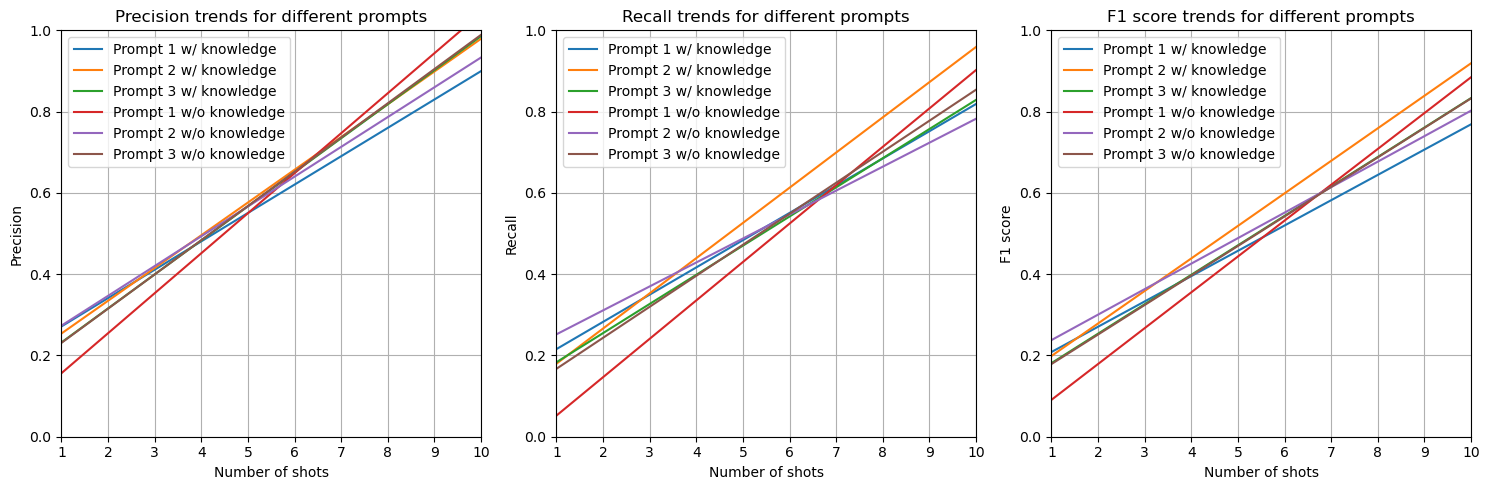

In [211]:
def plot_metrics(ax, metric, atype):
    labels = ['Precision', 'Recall', 'F1 score']

    x = np.array(range(1, 11))

    for i in range(len(metric)):
        prompt = []

        for j in range(len(metric[i])):
            prompt.append(metric[i][j])

        z = np.polyfit(x, prompt, 1)
        p = np.poly1d(z)
        
        if i < 3:
            ax.plot(x, p(x), label=f'Prompt {i+1} w/ knowledge')
        else:
            ax.plot(x, p(x), label=f'Prompt {i-2} w/o knowledge')

    ax.set_xlabel('Number of shots')
    ax.set_ylabel(f'{labels[atype]}')
    ax.set_title(f'{labels[atype]} trends for different prompts')
    ax.legend()
    ax.grid()
    ax.set_xlim(1, 10)
    ax.set_ylim(0, 1)
    
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

plot_metrics(axs[0], precision_list, 0)
plot_metrics(axs[1], recall_list, 1)
plot_metrics(axs[2], f1_list, 2)

plt.tight_layout()
plt.savefig(os.path.join('figures', 'specific_all_metrics_trend.pdf'), format='pdf')
plt.show()

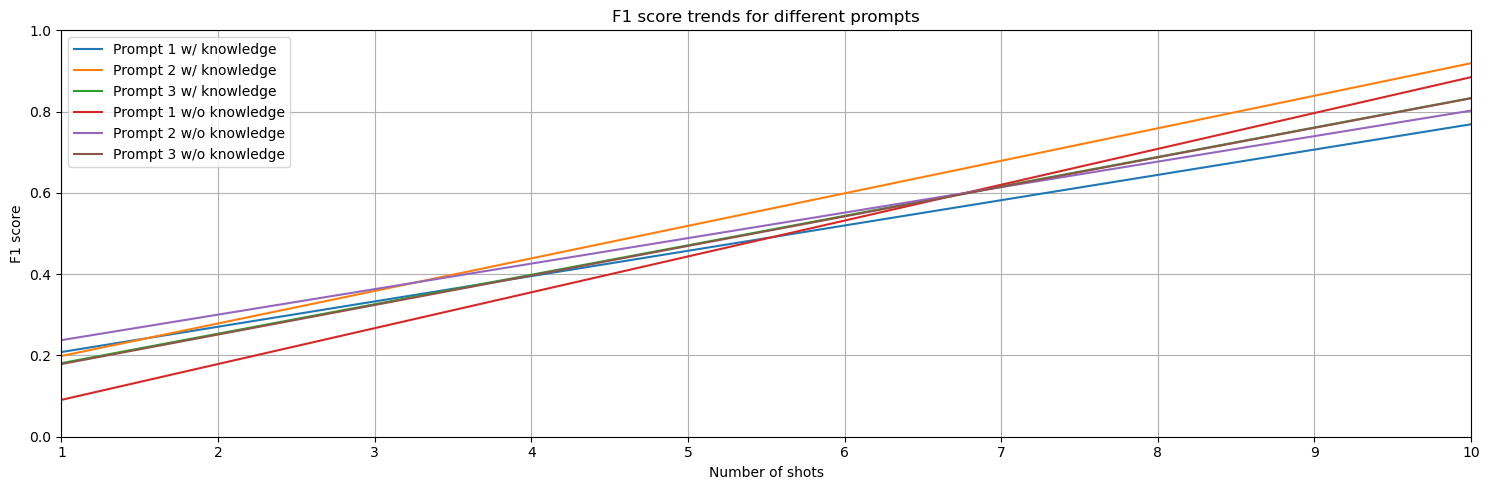

In [214]:
def f1_plot(axs, metric):
    x = np.array(range(1, 11))

    for i in range(len(metric)):
        prompt = []

        for j in range(len(metric[i])):
            prompt.append(metric[i][j])

        z = np.polyfit(x, prompt, 1)
        p = np.poly1d(z)
        
        if i < 3:
            ax.plot(x, p(x), label=f'Prompt {i+1} w/ knowledge')
        else:
            ax.plot(x, p(x), label=f'Prompt {i-2} w/o knowledge')

    ax.set_xlabel('Number of shots')
    ax.set_ylabel('F1 score')
    ax.set_title('F1 score trends for different prompts')
    ax.legend()
    ax.grid()
    ax.set_xlim(1, 10)
    ax.set_ylim(0, 1)
    
fig, axs = plt.subplots(1, 1, figsize=(15, 5))

plot_metrics(axs, f1_list, 2)

plt.tight_layout()
plt.savefig(os.path.join('figures', 'specific_f1_trend.pdf'), format='pdf')
plt.show()

In [ ]:
# instances, predicates and goals in each sublist respectively
unlabeled = [[
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
            0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 
            1,0, 0, 0, 1,1,1,0, 1, 1, 1, 1, 1, 0,  0,  1, 0,  0,  0,  0,  0,  0,  1, 1, 0,  1, 0,  0,  0,  0,  1,
            1,1,1,1,0, 0, 0, 1,1, 0,  0,  1, 1, 0,  1, 1, 1, 1, 0,  0,  0,  1, 1, 0,  1, 1, 1, 0,  1, 0,  1,
            1,0, 0, 1,0, 0, 0, 0, 0,  0,  1, 1, 1, 0,  0,  1, 0,  0,  0,  0,  1, 0,  0,  1, 1, 1, 1, 0,  0,  1, 1,
            0, 0, 0, 0, 0, 0, 1,0, 1, 0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 
            1,1,0, 1,0, 1,0, 0, 0,  0,  0,  0,  0,  1, 0,  1, 0,  0,  0,  1, 1, 1, 0,  0,  0,  1, 1, 0,  0,  1, 0, 
            1,1,0, 1,0, 0, 0, 1,0,  0,  1, 0,  1, 1, 0,  0,  0,  0,  1, 0,  1, 0,  0,  1, 0,  1, 1, 1, 1, 0,  0, 
            0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  1, 0,  0, 
            ],
            [    
            0, 0, 0, 1,0, 0, 0, 0, 0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  1, 0, 
            0, 0, 1,0, 0, 0, 1,0, 1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  1, 1, 0,  0,  0,  0,  1, 1, 0,  0, 
            0, 0, 0, 0, 1,1,0, 0, 0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  1, 0,  1, 0,  0,  0,  0,  0,  0, 
            0, 0, 0, 0, 1,0, 1,0, 1, 0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0, 
            0, 0, 0, 1,0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 1, 0,  0,  0,  0,  0,  0,  0,  0, 
            1,1,1,0, 0, 0, 1,1,0,  1, 0,  0,  0,  1, 0,  0,  1, 0,  1, 1, 0,  1, 0,  0,  0,  0,  0,  1, 0,  1, 0, 
            0, 0, 0, 0, 0, 0, 1,0, 1, 0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 
            0, 0, 0, 1,0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0, 
            0, 0, 0, 0, 0, 0, 0, 1,0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 
            0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  1, 0,  0, 
            ],
            [
            0, 0, 0, 1,0, 0, 0, 0, 0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  1, 0, 
            0, 0, 0, 0, 0, 0, 1,0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  1, 1, 0,  1, 1, 0,  0, 
            0, 0, 0, 0, 1,0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  1, 0,  0,  0,  0,  0,  0, 
            0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0, 
            0, 0, 0, 1,0, 0, 1,0, 1, 0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  1, 1, 0,  0,  0,  0,  0,  0,  0,  0, 
            0, 1,1,0, 1,0, 1,0, 0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 1, 0, 
            0, 0, 0, 0, 0, 0, 1,1,1, 0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 
            0, 0, 0, 1,0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 
            0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  1, 1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0, 
            0, 0, 0, 0, 0, 0, 0, 0, 0,  1, 0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  1, 0,  0, 
            ]]

labeled = [[
            0, 1,0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  1, 0,  1, 1, 0,  0,  0, 
            0, 0, 1,1,0, 0, 0, 1,0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0, 
            0, 0, 0, 0, 1,0, 0, 0, 1, 0,  0,  0,  1, 0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0, 
            1,0, 0, 1,0, 1,0, 0, 1, 0,  1, 1, 1, 0,  0,  0,  0,  0,  0,  1, 1, 1, 0,  0,  1, 1, 0,  0,  0,  0,  1,
            0, 1,1,1,1,0, 1,0, 1, 0,  0,  1, 1, 1, 0,  0,  1, 0,  0,  0,  1, 1, 1, 1, 1, 0,  1, 0,  1, 1, 0, 
            1,0, 1,0, 0, 1,0, 1,0,  0,  1, 0,  0,  1, 1, 1, 0,  0,  0,  0,  1, 0,  1, 1, 1, 1, 1, 0,  0,  0,  1,
            0, 0, 0, 0, 0, 0, 0, 1,0,  0,  0,  0,  1, 0,  0,  0,  1, 1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0, 
            1,0, 0, 1,0, 0, 0, 0, 0,  0,  1, 1, 0,  0,  1, 1, 1, 0,  0,  0,  0,  0,  1, 0,  0,  1, 0,  0,  0,  0,  1,
            0, 0, 0, 0, 1,0, 0, 1,1, 0,  0,  0,  1, 0,  0,  0,  0,  1, 1, 0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  1, 0, 
            0, 0, 0, 0, 0, 0, 1,0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0, 
            ],
            [
            0, 1,0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  1, 0,  1, 1, 0, 0, 0,
            0,0,1,0,0,0,1,1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,0,0,0,0,0,0,0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,0,1,0,0,0,0,1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
            0,0,0,0,0,0,0,0,0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,1,1,1,0,0,0,0,0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
            0,0,0,0,0,0,0,0,0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,0,1,0,0,0,0,0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,0,0,0,0,1,0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
            ],
            [
            0,1,0,0,0,0,0,0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
            0,0,0,0,0,0,0,1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,0,0,0,0,0,0,0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,0,1,0,0,0,0,1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
            0,0,0,0,0,0,0,1,0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,1,1,0,0,0,0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
            0,0,0,0,0,0,0,1,0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,0,1,0,0,0,0,0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,0,1,1,0,0,0,0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
            0,0,0,0,0,0,1,0,0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
            ]]

total = [1 if all(sublist[i] == 1 for sublist in unlabeled) else 0 for i in range(len(unlabeled[0]))]
total_labeled = [1 if all(sublist[i] == 1 for sublist in labeled) else 0 for i in range(len(labeled[0]))]

unlabeled_arr = np.array(total)
unlabeled = unlabeled_arr.reshape(10, 31)

labeled_arr = np.array(total_labeled)
labeled = labeled_arr.reshape(10, 31)

In [ ]:
def plot_heatmaps(labeled, unlabeled):
    fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

    # Plot unlabeled heatmap
    ax1 = sns.heatmap(unlabeled, cmap='binary', ax=axs[0], cbar=False)
    ax1.set_yticklabels(range(1, 11))
    ax1.set_xticklabels(range(2, 33))
    ax1.set_title('Correct instances, predicates and goals (unlabeled shot set)')
    ax1.set_ylabel('Test set')
    ax1.set_xlabel('Number of shots')

    # Plot labeled heatmap
    ax2 = sns.heatmap(labeled, cmap='binary', ax=axs[1], cbar=False)
    ax2.set_yticklabels(range(1, 11))
    ax2.set_xticklabels(range(2, 33))
    ax2.set_title('Correct instances, predicates and goals (unlabeled shot set)')
    ax2.set_ylabel('Test set')
    ax2.set_xlabel('Number of shots')

    # fig.suptitle('Heatmaps of test sets with all correct predictions')

    plt.tight_layout()
    plt.show()

    # save to pdf
    # fig.savefig('heatmaps.pdf')

plot_heatmaps(labeled, unlabeled)